In [1]:
##パラメータ数が多すぎて学習が止まる恐れあり

import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
z_hidden_size=20#隠れ次元
dim_label=1#真画像、偽画像#この変換はあとで行う
dim_image_size=100#64*64の画像#遊び中は80仕事は60

In [4]:
"""
パラメータが多くなりすぎたため使用しない
"""
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


In [5]:
#生成器4層#5層はいらんかな。
class Generator(nn.Module):#z_dimから始めてimage_sizeに持っていく#これをもとに作っていこう
    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):#20に意味はない
        super(Generator,self).__init__()
        #層1:z_dim->image_size*16
        self.layer1=nn.Sequential(
            nn.ConvTranspose2d(z_dim,image_size*8,kernel_size=6,stride=3),#畳み込み層
            nn.BatchNorm2d(image_size*8),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層2:image_size*8->image_size*4
        self.layer2=nn.Sequential(
            nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=6,stride=2,padding=2),#畳み込み層
            nn.BatchNorm2d(image_size*4),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層3:image_size*4->image_size*2
        self.layer3=nn.Sequential(
            nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=5,stride=3,padding=2),#畳み込み層
            nn.BatchNorm2d(image_size*2),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層4:image_size*2->image_size
        self.layer4=nn.Sequential(
            nn.ConvTranspose2d(image_size*2,image_size,kernel_size=5,stride=3,padding=2),#畳み込み層
            nn.BatchNorm2d(image_size),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)

        #最終層
        self.last=nn.Sequential(
            nn.ConvTranspose2d(image_size,1,kernel_size=4,stride=2,padding=1),
            nn.Tanh())
        
    def forward(self,z):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        out=self.layer1(z)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        return out

In [6]:
#生成器(識別器生成用)
"""
class Generator(nn.Module):#z_dimから始めてimage_sizeに持っていく#これをもとに作っていこう
    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):#20に意味はない
        super(Generator,self).__init__()
        #層1:z_dim->image_size*16
        self.layer1=nn.Sequential(
            nn.ConvTranspose2d(z_dim,image_size*8,kernel_size=7,stride=1),#畳み込み層
            nn.BatchNorm2d(image_size*8),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層2:image_size*8->image_size*4
        self.layer2=nn.Sequential(
            nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=5,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size*4),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層3:image_size*4->image_size*2
        self.layer3=nn.Sequential(
            nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=7,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size*2),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層4:image_size*2->image_size
        self.layer4=nn.Sequential(
            nn.ConvTranspose2d(image_size*2,image_size,kernel_size=5,stride=3,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #最終層
        self.last=nn.Sequential(
            nn.ConvTranspose2d(image_size,1,kernel_size=6,stride=2,padding=1),
            nn.Tanh())
        
    def forward(self,z):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        out=self.layer1(z)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        return out"""

'\nclass Generator(nn.Module):#z_dimから始めてimage_sizeに持っていく#これをもとに作っていこう\n    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):#20に意味はない\n        super(Generator,self).__init__()\n        #層1:z_dim->image_size*16\n        self.layer1=nn.Sequential(\n            nn.ConvTranspose2d(z_dim,image_size*8,kernel_size=7,stride=1),#畳み込み層\n            nn.BatchNorm2d(image_size*8),#正規化\n            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)\n        #層2:image_size*8->image_size*4\n        self.layer2=nn.Sequential(\n            nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=5,stride=2,padding=1),#畳み込み層\n            nn.BatchNorm2d(image_size*4),#正規化\n            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)\n        #層3:image_size*4->image_size*2\n        self.layer3=nn.Sequential(\n            nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=7,stride=2,padding=1),#畳み込み層\n            nn.BatchNorm2d(image_size*2),#正規化\n            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)\n       

(200, 200)


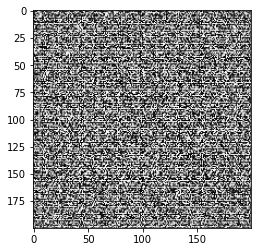

In [7]:
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""
G=Generator(z_dim=z_hidden_size,image_size=dim_image_size)###################
#print(z_hidden_size)
input_z=torch.randn(1,z_hidden_size)#テンソルサイズを(1,40)で乱数生成
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルサイズを(1,40,1,1)に変更
fake_images=G(input_z)
img_transformed=fake_images[0][0].detach().numpy()
print(img_transformed.shape)
plt.imshow(img_transformed,"gray")
plt.show()

In [8]:
#識別器4層#kernelsizeはgeneratorと逆
class Discriminator(nn.Module):
    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):
        super(Discriminator,self).__init__()
        #1層:真画像、偽画像->image_size
        self.layer1=nn.Sequential(
            nn.Conv2d(1,image_size,kernel_size=6,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #2層:image_size->image_size*2
        self.layer2=nn.Sequential(
            nn.Conv2d(image_size,image_size*2,kernel_size=5,stride=3,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #3層:image_size*2->image_size*4
        self.layer3=nn.Sequential(
            nn.Conv2d(image_size*2,image_size*4,kernel_size=7,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))

        # Self-Attention層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        #4層:image_size*4->image_size*8
        self.layer4=nn.Sequential(
            nn.Conv2d(image_size*4,image_size*8,kernel_size=5,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        

        # Self-Attention層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        #最終層:image_size*8->真偽
        self.last=nn.Conv2d(image_size*8,1,kernel_size=7,stride=1)
    
    def forward(self,x):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        return out

In [9]:
D=Discriminator(z_dim=z_hidden_size,image_size=dim_image_size)####################

input_z=torch.randn(1,z_hidden_size)#テンソル(1,20)
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)
fake_images=G(input_z)
d_out=D(fake_images)
print(nn.Sigmoid()(d_out))

tensor([[[[0.4964]]]], grad_fn=<SigmoidBackward>)


In [10]:
def make_datapath_list():#あとはディレクトリを作れば起動
    train_img_list=list()#画像ファイルパスを格納list():[]
    #"""遊び
    for img_idx in range(34):
        img_path="./data/anime_character/Na-Ga/img_200/Na-Ga"+str(img_idx+1000)+".bmp"
        #img_path="./data/anime_character/saber/saber000"+str(img_idx+1)+".bmp"
        train_img_list.append(img_path)
    """
    for img_idx in range(200):#200枚ずつ
        img_path="./data/img_78/img_7_"+str(img_idx)+".jpg"#使用画像のパスを変更すること
        train_img_list.append(img_path)
        
        img_path="./data/img_78/img_8_"+str(img_idx)+".jpg"
        train_img_list.append(img_path)
        """#for_saber"""
    return train_img_list

class ImageTransform():
    """画像の前処理"""
    def __init__(self,mean,std):#正規化
        self.data_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
    
    def __call__(self,img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス、pytorchのdatasetクラスを継承"""
    #ここで定義していないメソッドはdatasetクラスにあると思われる
    def __init__(self,file_list,transform):
        self.file_list=file_list
        self.transform=transform
    
    def __len__(self):
        """画像枚数を返す"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        """前処理をした画像のTensor形式のデータを取得"""
        
        img_path=self.file_list[index]
        img=Image.open(img_path)#[高さ][幅]白黒
        
        #画像の前処理
        img_transformed=self.transform(img)
        
        return img_transformed


train_img_list=make_datapath_list()

mean=(0.5,)
std=(0.5,)
train_dataset=GAN_Img_Dataset(
    file_list=train_img_list,
    transform=ImageTransform(mean,std))

batch_size=64
train_dataloader=torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size,shuffle=True)

batch_iterator=iter(train_dataloader)#イテレータに変換
imges=next(batch_iterator)#1番目の要素を取り出す
print(imges.size())

torch.Size([34, 1, 200, 200])


In [11]:
#"""
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find("Conv")!=-1:
        #Conv2d,ConvTranspose2dの初期化
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.bias.data,0)
    elif classname.find("BatchNorm")!=-1:
        #BatchNorm2dを初期化
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
G.apply(weights_init)
D.apply(weights_init)
print("ネットワーク初期化完了")
"""###"""

ネットワーク初期化完了


'###'

In [12]:
def train_model(G,D,dataloader,num_epochs):
    #GPU確認
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    g_lr=0.0008
    d_lr=0.0008#学習率
    beta1=0.0
    beta2=0.9
    g_optimizer=torch.optim.Adam(G.parameters(),g_lr,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),d_lr,[beta1,beta2])
    
    #損失関数を定義
    criterion=nn.BCEWithLogitsLoss(reduction="mean")#ここがerrorを吐いてるかもしれない
    
    #パラメータをハードコーディング
    z_dim=z_hidden_size
    mini_batch_size=10
    
    #ネットワークをGPUへ
    G.to(device)
    D.to(device)
    
    G.train()#モデルを訓練モードに
    D.train()#モデルを訓練モードに
    
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    #画像の枚数
    num_train_imgs=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    logs=[]
    
    #epochのループ
    for epoch in range(num_epochs):
        #開始時刻を保持
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_d_loss=0.0
        #print("---")
        print("Epoch{}/{}".format(epoch,num_epochs))
        #print("---")
        #print("(train)")
        
        #データローダーからminibatchずつ取り出す
        for imges in dataloader:
            #1:Discriminatorの学習
            #minibatchサイズ1だとバッチノーマライゼーションでエラー発生
            if imges.size()[0]==1:
                continue
            #GPU使用できるときGPUに流す
            imges=imges.to(device)
            
            #ラベル作成#下に修正作業あり
            mini_batch_size=imges.size()[0]
            label_real=torch.full((mini_batch_size,),1).to(device)
            label_fake=torch.full((mini_batch_size,),0).to(device)
            
            #真画像判定
            d_out_real=D(imges)
            
            #偽画像生成&判定
            input_z=torch.randn(mini_batch_size,z_dim).to(device)
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            label_real=label_real.type_as(d_out_real.view(-1))#テンソルの平坦化
            d_loss_real=criterion(d_out_real.view(-1),label_real)
            label_fake=label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            d_loss=d_loss_real+d_loss_fake
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            #2:Generatorの学習
            #偽画像生成&判定
            input_z=torch.randn(mini_batch_size,z_dim).to(device)#minibatch個のz_dim生成->GPUへ
            input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            """label_real=label_real.type_as(d_out_real.view(-1))"""#計算でエラーが出たらここを変更
            g_loss=criterion(d_out_fake.view(-1),label_real)
            
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            
            #3:記録
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            iteration+=1
        
        #epochのphaseごとのlossと正答率
        t_epoch_finish=time.time()
        #print("---")
        print("epoch{}||Epoch_D_Loss:{:.4f}||Epoch_G_Loss:{:.4f}".format(epoch,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print("timer:{:.4f}sec.".format(t_epoch_finish-t_epoch_start))
        t_epoch_start=time.time()
        
    return G,D

In [13]:
#学習#
params_D = 0
params_G=0
for p in D.parameters():
    if p.requires_grad:
        params_D += p.numel()
for p in G.parameters():
    if p.requires_grad:
        params_G += p.numel()
print(params_D)  # 121898
print(params_G)
num_epochs=100
G_update,D_update=train_model(G,D,dataloader=train_dataloader,num_epochs=num_epochs)

13465803
14602101
使用デバイス: cuda:0
Epoch0/100
epoch0||Epoch_D_Loss:0.0270||Epoch_G_Loss:0.0000
timer:3.4678sec.
Epoch1/100
epoch1||Epoch_D_Loss:0.2671||Epoch_G_Loss:0.0086
timer:0.3525sec.
Epoch2/100
epoch2||Epoch_D_Loss:0.1083||Epoch_G_Loss:0.0671
timer:0.3527sec.
Epoch3/100
epoch3||Epoch_D_Loss:0.0053||Epoch_G_Loss:0.2660
timer:0.3563sec.
Epoch4/100
epoch4||Epoch_D_Loss:0.0039||Epoch_G_Loss:0.1980
timer:0.3409sec.
Epoch5/100
epoch5||Epoch_D_Loss:0.0320||Epoch_G_Loss:0.0683
timer:0.3681sec.
Epoch6/100
epoch6||Epoch_D_Loss:0.0065||Epoch_G_Loss:0.0710
timer:0.3559sec.
Epoch7/100
epoch7||Epoch_D_Loss:0.0194||Epoch_G_Loss:0.1228
timer:0.3438sec.
Epoch8/100
epoch8||Epoch_D_Loss:0.1090||Epoch_G_Loss:0.0296
timer:0.3496sec.
Epoch9/100
epoch9||Epoch_D_Loss:0.0080||Epoch_G_Loss:0.0383
timer:0.3684sec.
Epoch10/100
epoch10||Epoch_D_Loss:0.0055||Epoch_G_Loss:0.0551
timer:0.3474sec.
Epoch11/100
epoch11||Epoch_D_Loss:0.0041||Epoch_G_Loss:0.0728
timer:0.3671sec.
Epoch12/100
epoch12||Epoch_D_Loss:0.003

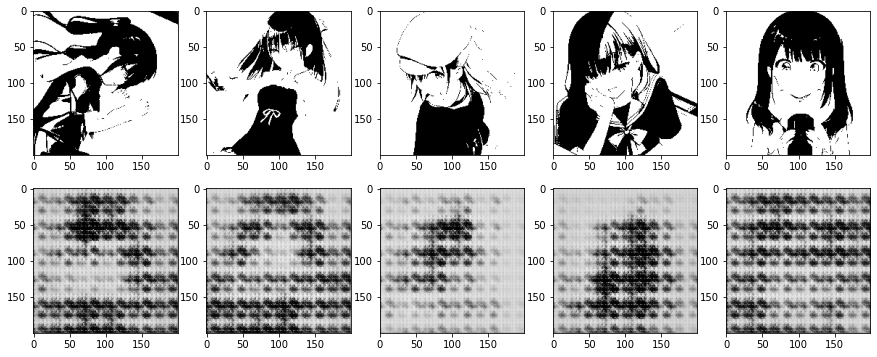

In [14]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
count=3100
#入力の乱数生成
batch_size=8
z_dim=z_hidden_size
fixed_z=torch.randn(batch_size,z_dim)
fixed_z=fixed_z.view(fixed_z.size(0),fixed_z.size(1),1,1)

#画像生成
G_update.eval()
fake_images=G_update(fixed_z.to(device))

#訓練データ
batch_iterator=iter(train_dataloader)
imgs=next(batch_iterator)#1番目の要素を取り出す

#出力
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    #上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),"gray")
    
    #下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),"gray")

In [452]:
#ネットワーク保存
model_path_d = 'model_d.pth'
torch.save(D.state_dict(), model_path_d)
model_path_g="model_g.pth"
torch.save(G.state_dict(),model_path_g)

In [466]:
#ネットワークロード
model_path_d = 'model_d.pth'
D=D.load_state_dict(torch.load(model_path_d))
model_path_g = 'model_g.pth'
G=G.load_state_dict(torch.load(model_path_g))

In [140]:
#ネットワーク保存(特殊ver)
count=1100
model_path_d = "model_d_"+str(count)+".pth"
torch.save(D.state_dict(), model_path_d)
model_path_g="model_g_"+str(count)+".pth"
torch.save(G.state_dict(),model_path_g)

In [38]:
#ネットワークロード(特殊ver)#ロードはできても学習はさせられないっぽい(?)
count=1100
model_path_d = "model_d_"+str(count)+".pth"
D=D.load_state_dict(torch.load(model_path_d))
model_path_g="model_g_"+str(count)+".pth"
G=G.load_state_dict(torch.load(model_path_g))

RuntimeError: Error(s) in loading state_dict for Discriminator:
	Missing key(s) in state_dict: "self_attntion1.gamma", "self_attntion1.query_conv.weight", "self_attntion1.query_conv.bias", "self_attntion1.key_conv.weight", "self_attntion1.key_conv.bias", "self_attntion1.value_conv.weight", "self_attntion1.value_conv.bias", "self_attntion2.gamma", "self_attntion2.query_conv.weight", "self_attntion2.query_conv.bias", "self_attntion2.key_conv.weight", "self_attntion2.key_conv.bias", "self_attntion2.value_conv.weight", "self_attntion2.value_conv.bias". 

In [ ]:
#5層のコピー
"""
#生成器4層#5層はいらんかな。
class Generator(nn.Module):#z_dimから始めてimage_sizeに持っていく#これをもとに作っていこう
    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):#20に意味はない
        super(Generator,self).__init__()
        #層1:z_dim->image_size*16
        self.layer1=nn.Sequential(
            nn.ConvTranspose2d(z_dim,image_size*16,kernel_size=6,stride=1),#畳み込み層
            nn.BatchNorm2d(image_size*16),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層1.5:image_size*16->image_size*8
        self.layer1_5=nn.Sequential(
            nn.ConvTranspose2d(image_size*16,image_size*8,kernel_size=4,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size*8),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層2:image_size*8->image_size*4
        self.layer2=nn.Sequential(
            nn.ConvTranspose2d(image_size*8,image_size*4,kernel_size=5,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size*4),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層3:image_size*4->image_size*2
        self.layer3=nn.Sequential(
            nn.ConvTranspose2d(image_size*4,image_size*2,kernel_size=4,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size*2),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #層4:image_size*2->image_size
        self.layer4=nn.Sequential(
            nn.ConvTranspose2d(image_size*2,image_size,kernel_size=4,stride=2,padding=1),#畳み込み層
            nn.BatchNorm2d(image_size),#正規化
            nn.ReLU(inplace=True))#ReLU(スイッチのイメージ)
        #最終層
        self.last=nn.Sequential(
            nn.ConvTranspose2d(image_size,1,kernel_size=4,stride=2,padding=1),
            nn.Tanh())
        
    def forward(self,z):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        out=self.layer1(z)
        out=self.layer1_5(out)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.last(out)
        return out
"""

In [ ]:
#5層のコピー
"""
#識別器4層#kernelsizeはgeneratorと逆
class Discriminator(nn.Module):
    def __init__(self,z_dim=z_hidden_size,image_size=dim_image_size):
        super(Discriminator,self).__init__()
        #1層:真画像、偽画像->image_size
        self.layer1=nn.Sequential(
            nn.Conv2d(1,image_size,kernel_size=4,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #2層:image_size->image_size*2
        self.layer2=nn.Sequential(
            nn.Conv2d(image_size,image_size*2,kernel_size=4,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #3層:image_size*2->image_size*4
        self.layer3=nn.Sequential(
            nn.Conv2d(image_size*2,image_size*4,kernel_size=4,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #4層:image_size*4->image_size*8
        self.layer4=nn.Sequential(
            nn.Conv2d(image_size*4,image_size*8,kernel_size=5,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #5層:image_size*8->image_size*16
        self.layer5=nn.Sequential(
            nn.Conv2d(image_size*8,image_size*16,kernel_size=4,stride=2,padding=True),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #最終層:image_size*8->真偽
        self.last=nn.Conv2d(image_size*16,1,kernel_size=6,stride=1)
    
    def forward(self,x):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.layer5(out)
        out=self.last(out)
        return out
"""

In [476]:
"""##############xを定義するまで使用できません
#Dの損失関数イメージ
#BinaryCrossEntropy#maximize log(D(X))+log(1-D(G(Z)))
#xの定義で使用可能
"""

"""
mini_batch_size=2
label_real=torch.full((mini_batch_size,),1)#テンソル決定、値はすべて1
label_fake=torch.full((mini_batch_size,),0)#テンソル決定、値はすべて0

criterion=nn.BCEWithLogitsLoss(reduction="mean")#損失関数を定義

d_out_real=D(x)#真画像を判定
input_z=torch.randn(mini_batch_size,20)#20次元の種となるテンソル作成、*mini_batch数
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変形
fake_images=G(input_z)
d_out_fake=D(fake_images)

#損失計算
d_loss_real=criterion(d_out_real.view(-1),label_real)
d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
d_loss=d_loss_real+d_loss_fake

"""

'\nmini_batch_size=2\nlabel_real=torch.full((mini_batch_size,),1)#テンソル決定、値はすべて1\nlabel_fake=torch.full((mini_batch_size,),0)#テンソル決定、値はすべて0\n\ncriterion=nn.BCEWithLogitsLoss(reduction="mean")#損失関数を定義\n\nd_out_real=D(x)#真画像を判定\ninput_z=torch.randn(mini_batch_size,20)#20次元の種となるテンソル作成、*mini_batch数\ninput_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変形\nfake_images=G(input_z)\nd_out_fake=D(fake_images)\n\n#損失計算\nd_loss_real=criterion(d_out_real.view(-1),label_real)\nd_loss_fake=criterion(d_out_fake.view(-1),label_fake)\nd_loss=d_loss_real+d_loss_fake\n\n'

In [477]:
"""##############xを定義するまで使用できません
#Gの損失関数イメージ
#maximize log(D(G(z)))
#xの定義で使用可能
"""

"""
input_z=torch.randn(mini_batch_size,20)#20次元の種となるテンソル作成、*mini_batch数
input_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変形
fake_images=G(input_z)
d_out_fake=D(fake_images)


g_loss_fake=criterion(d_out_fake.view(-1),label_fake)
"""

'\ninput_z=torch.randn(mini_batch_size,20)#20次元の種となるテンソル作成、*mini_batch数\ninput_z=input_z.view(input_z.size(0),input_z.size(1),1,1)#テンソルの形を変形\nfake_images=G(input_z)\nd_out_fake=D(fake_images)\n\n\ng_loss_fake=criterion(d_out_fake.view(-1),label_fake)\n'